In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

In [121]:
Dynamics1 = pd.read_csv("Dynamics365_AllReviews.csv")
Dynamics2 = pd.read_csv("Dynamics365_First100Reviews.csv")

In [122]:
# Looking at the columns and length of above two data sets before merging them
print(len(Dynamics1))
print(len(Dynamics2))
print(Dynamics1.columns)
print(Dynamics2.columns)

2753
100
Index(['Main_comment', 'Reviewed_On', 'Reviewer_name', 'Reviewer_Role',
       'Reviewer_Department_company', 'Review_Comments'],
      dtype='object')
Index(['Main_comment', 'Reviewed_On', 'Reviewer_name', 'Reviewer_Role',
       'Reviewer_Department_company', 'Review_Comments'],
      dtype='object')


In [123]:
# Merging the data with df.append()
Dynamics365_Data = Dynamics2.append(Dynamics1,ignore_index=True)

In [124]:
print(len(Dynamics365_Data))
print(Dynamics365_Data.columns)

2853
Index(['Main_comment', 'Reviewed_On', 'Reviewer_name', 'Reviewer_Role',
       'Reviewer_Department_company', 'Review_Comments'],
      dtype='object')


In [125]:
# looking at data types of each column
Dynamics365_Data.dtypes

Main_comment                   object
Reviewed_On                    object
Reviewer_name                  object
Reviewer_Role                  object
Reviewer_Department_company    object
Review_Comments                object
dtype: object

In [126]:
'''Reviewed on Might be helpful for other exploratory analysis but not for our text analysis
Reviewer name also can be exluded out of data
let us see if reviewer role can be coverted to factor and utilized for further analysis. For this lets look at number of unique
values within this attribute'''
#Dynamics365_Data['Reviewer_Role'].unique()
print("Number of unique values within Reviewer role : ", len(Dynamics365_Data['Reviewer_Role'].unique()))
print("Number of values within reviewer role : ", len(Dynamics365_Data['Reviewer_Role']))

Number of unique values within Reviewer role :  1215
Number of values within reviewer role :  2853


In [127]:
# lets convert Reviewer_Role attribute to categorical and decide later whether to use it for model building or not
Dynamics365_Data['Reviewer_Role'] = Dynamics365_Data['Reviewer_Role'].astype('category')

In [128]:
Dynamics365_Data.dtypes

Main_comment                     object
Reviewed_On                      object
Reviewer_name                    object
Reviewer_Role                  category
Reviewer_Department_company      object
Review_Comments                  object
dtype: object

In [129]:
Dynamics365_Data.Reviewer_Department_company.head()

0    \r\n                Non-Profit Organization Ma...
1    \r\n                51-200 employees\r\n      ...
2    \r\n                Food & Beverages, 51-200 e...
3    \r\n                Public Relations and Commu...
4               \r\n                \r\n              
Name: Reviewer_Department_company, dtype: object

In [130]:
Dynamics365_Data.Reviewer_Department_company = Dynamics365_Data.Reviewer_Department_company.str.replace("\r\n                ","")
Dynamics365_Data.Reviewer_Department_company = Dynamics365_Data.Reviewer_Department_company.str.replace("\r\n","")
Dynamics365_Data.Reviewer_Department_company = Dynamics365_Data.Reviewer_Department_company.str.replace("                ","")

In [131]:
Dynamics365_Data.Reviewer_Department_company.str.strip()

0       Non-Profit Organization Management, 11-50 empl...
1                                        51-200 employees
2                      Food & Beverages, 51-200 employees
3       Public Relations and Communications, 51-200 em...
4                                                        
5                            Banking, 1001-5000 employees
6                                                        
7                              Machinery, 11-50 employees
8                   Financial Services, 201-500 employees
9                                      Building Materials
10                                                       
11                   Computer Software, 201-500 employees
12                Management Consulting, 51-200 employees
13                                                       
14                                        11-50 employees
15                                      201-500 employees
16                                       51-200 employees
17            

In [132]:
Dynamics365_Data.isna().sum()

Main_comment                     62
Reviewed_On                       0
Reviewer_name                     0
Reviewer_Role                  1088
Reviewer_Department_company       0
Review_Comments                  61
dtype: int64

In [133]:
Dynamics365_Data['Review_Comments'].isna().sum()

61

In [134]:
Dynamics365_Data.columns

Index(['Main_comment', 'Reviewed_On', 'Reviewer_name', 'Reviewer_Role',
       'Reviewer_Department_company', 'Review_Comments'],
      dtype='object')

In [135]:
# FOrming this new data set to drop all the NA values, we shall be not considering Reviewer role in this data as,
# it has lot of NA values and we cannot be dropping all of them. Moreover Reviewer role is not being used for further analysis
D365_DroppingNas = Dynamics365_Data[['Main_comment', 'Reviewed_On', 'Reviewer_name','Reviewer_Department_company', 'Review_Comments']]
print(D365_DroppingNas.isna().sum())

Main_comment                   62
Reviewed_On                     0
Reviewer_name                   0
Reviewer_Department_company     0
Review_Comments                61
dtype: int64


In [136]:
D365_DroppingNas = D365_DroppingNas.dropna()
print(D365_DroppingNas.isna().sum())

Main_comment                   0
Reviewed_On                    0
Reviewer_name                  0
Reviewer_Department_company    0
Review_Comments                0
dtype: int64


In [141]:
# Taking the human redable comments into another data frame,for easy labelling of new entity for NER at a later point of time
D365_DroppingNas_HumanRedable = pd.DataFrame()
D365_DroppingNas_HumanRedable['Review_Comments'] = D365_DroppingNas['Review_Comments']
print(D365_DroppingNas_HumanRedable['Review_Comments'].head())
print("\nLenght of this new data frame: ", len(D365_DroppingNas_HumanRedable))
print("Lenght of data frame used for further processing: ", len(D365_DroppingNas))
print("Just looking at above length to understand if the Human redable dataset and the one we are going to process further have the same length or not")

0     Everything in one place such as Sales, Market...
1     \r\n,1296/5000\r\n,Like any CRM software, Mic...
2     What I like most about Microsoft Dynamics is ...
3     There are a few things that I really love abo...
4     Easy to use, not expensive, simply to navigat...
Name: Review_Comments, dtype: object

Lenght of this new data frame:  2791
Lenght of data frame used for further processing:  2791
Just looking at above length to understand if the Human redable dataset and the one we are going to process further have the same length or not


In [23]:
#Removing all symbols sort of things
D365_DroppingNas['Review_Comments'] = D365_DroppingNas['Review_Comments'].apply(lambda x : re.sub(r'\W+',' ',str(x)))

In [24]:
D365_DroppingNas['Review_Comments'].head()

0     Everything in one place such as Sales Marketi...
1     1296 5000 Like any CRM software Microsoft Dyn...
2     What I like most about Microsoft Dynamics is ...
3     There are a few things that I really love abo...
4     Easy to use not expensive simply to navigate ...
Name: Review_Comments, dtype: object

In [25]:
print(D365_DroppingNas['Review_Comments'].head())
print("\nTotal number of reviews available: ", len(D365_DroppingNas))

0     Everything in one place such as Sales Marketi...
1     1296 5000 Like any CRM software Microsoft Dyn...
2     What I like most about Microsoft Dynamics is ...
3     There are a few things that I really love abo...
4     Easy to use not expensive simply to navigate ...
Name: Review_Comments, dtype: object

Total number of reviews available:  2791


In [26]:
# Converting all of the review text to lower case
D365_DroppingNas['Review_Comments'] = D365_DroppingNas['Review_Comments'].apply(lambda x : " ".join(x.lower() for x in x.split()))
print(D365_DroppingNas['Review_Comments'].head())

0    everything in one place such as sales marketin...
1    1296 5000 like any crm software microsoft dyna...
2    what i like most about microsoft dynamics is t...
3    there are a few things that i really love abou...
4    easy to use not expensive simply to navigate i...
Name: Review_Comments, dtype: object


In [27]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
D365_DroppingNas['Review_Comments'] = D365_DroppingNas['Review_Comments'].apply(lambda x : " ".join(x for x in x.split() if x not in stop_words))
print(D365_DroppingNas['Review_Comments'].head())

0    everything one place sales marketing finance f...
1    1296 5000 like crm software microsoft dynamics...
2    like microsoft dynamics easy install set start...
3    things really love dynamics 365 d365 1 fully i...
4    easy use expensive simply navigate integration...
Name: Review_Comments, dtype: object


In [28]:
# From above data, we can clearly see stopwords are removed

In [29]:
# Now lemmatizing before we tokenize as we are not able to apply lemmatizer with 'apply' for a list
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
D365_DroppingNas['Review_Comments'] = D365_DroppingNas['Review_Comments'].apply(lambda x: " ".join(lemmatizer.lemmatize(x) for x in x.split()))
print(D365_DroppingNas['Review_Comments'].head())
print(D365_DroppingNas['Review_Comments'].tail())

0    everything one place sale marketing finance fi...
1    1296 5000 like crm software microsoft dynamic ...
2    like microsoft dynamic easy install set start ...
3    thing really love dynamic 365 d365 1 fully int...
4    easy use expensive simply navigate integration...
Name: Review_Comments, dtype: object
2845    exclusively use m want something kinda integra...
2846    easy look sale order posted invoice understand...
2847    easy use user friendly help completing task fa...
2849    system great need help support team always ava...
2851    like software maintains procedure regard feder...
Name: Review_Comments, dtype: object


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(D365_DroppingNas['Review_Comments'])

In [31]:
train_vect

<2791x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 56325 stored elements in Compressed Sparse Row format>

In [32]:
print("Just printing trained sparse matrix", train_vect)
print("\nTrying to look the type of this vector", type(train_vect))
print("\nShape of this sparse matrix : ", train_vect.shape)

Just printing trained sparse matrix   (0, 661)	0.06882427732456185
  (0, 776)	0.04979406945006425
  (0, 558)	0.06276927943178394
  (0, 351)	0.08372943276003426
  (0, 346)	0.07141940316257744
  (0, 807)	0.10425586830709624
  (0, 217)	0.0858525661240585
  (0, 616)	0.07073058109943696
  (0, 68)	0.07494323065453716
  (0, 70)	0.06497470954966653
  (0, 696)	0.11887885009373786
  (0, 557)	0.15122609045610072
  (0, 766)	0.07538667964217306
  (0, 915)	0.10810856224105914
  (0, 889)	0.05045476835138074
  (0, 278)	0.21409574084911065
  (0, 309)	0.2106976368996593
  (0, 209)	0.13225859758653793
  (0, 902)	0.05976696543685296
  (0, 709)	0.07888622374539517
  (0, 296)	0.09874878317792748
  (0, 730)	0.08411027093242274
  (0, 804)	0.09532877179277006
  (0, 698)	0.1007745330710151
  (0, 475)	0.10309060241750287
  :	:
  (2790, 199)	0.12753283994892647
  (2790, 515)	0.08536019610803106
  (2790, 839)	0.13694726392637632
  (2790, 293)	0.17529037829344885
  (2790, 55)	0.20972003987287574
  (2790, 881)	0.211

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
pos = []
neg = []
for review in D365_DroppingNas['Review_Comments']:
    print(review)
    ss = sid.polarity_scores(review)
    pos.append(sid.polarity_scores(review)['pos'])
    neg.append(sid.polarity_scores(review)['neg'])
    #for k in sorted(ss):
     #   print('{0}: {1}, '.format(k, ss[k]), end='')
    #print()

everything one place sale marketing finance field service customer service operation automation available product market right likable thing customer support dynamic see erp crm team provide enables real sense productive intelligent decision easy adopt accessing managing pc mobile web browser make accessible powerful look feel control feature ui different kind user another best thing make standout enterprise business edition fantastic come design functionality integration office 365 social apps give lot control feature security crm erp love look feel kinda mashup microsoft word outlook excel etc bit difficult use ease start knowledge curve first time microsoft product user little slower challenging first time user familiar microsoft product microsoft dynamic work business work come management draw chart needed provides accurate data deeply analysis filter make easier get exact data want integration office 360 sharepoint office online coolest part deployment much easy cost license deplo

like service application help manage specific business function financial sale operation marketing service automation well power microsoft cloud crm erp capability productivity application allow identifying capturing new opportunity since key part business connected also like empowered collaborate different geography give ability make decision take advantage new trend interrupt adapt wonderful connected system allow real time obtain aspect sale operation easily optimized controlled like least software difficult older staff assimilate small company perhaps employee finance carried manually le useful le useful think designed smes addition believe factor make economy stable taken account venezuela almost every day bolivar varies dollar many small business chosen offer product service dollar avoid losing income maintain financial stability company application decision making would uncertain however following example venezuela company make profit bolivar equally difficult maintain price var

sustains business multi stage sale process set crm support step workflow flow nicely created dashboard incentivize sale team add ons available enrich functionality example add lead contact marketing list sync mailchimp user interface could better reminds uis circa 2001 feeling developed techie techie microsoft took time improve interface end user allow user customize form using drag drop example would outstanding product another shortcoming amount customization requires writing code thing straightforward customize using workflow actually require programmer m dynamic indispensable management training company like give shout xrm spectacular job supporting product
program complete allows jointly manage planning business resource customer relationship management also intuitive handled similar way popular microsoft program easy implement company learning curve short program able automate relate several financial process time development per project allows generalized vision much earn projec

product facilitates administration client company allows know everything related client different module available example sale cycle user quickly know opportunity order invoice made client well quickly locate contact introducing user necessary information efficiently present different panel graphic information information within system change version crm dynamic javascripts used crm must verified updated crm update package allowed installed automatic update installed incorrectly compromise system must downloaded one one installed personnel one one avoid problem case crm premise better management information client case sale service marketing cycle order idea possibility extending creating new module manage type information desired provides additional capability platform meeting user need without need acquire software extending crm xrm library
use dynamic 365 across entire organization department use management project use project scheduling program meeting keeping track project also m

microsoft dynamic 365 used multiple department company use tracking incoming client request support implementation also allows member client facing application work together efficient manner software cloud solution help worker even work remotely addition software easy use easy teach new user customization feature blessing curse customize tend lag software also cumbersome implement dynamic 365 easy use software improved operation management organization staffing also product friendly end user interface
vendor dynamic crm seem understand customer key player sucess business result dynamic crm ability track manage customer information complaint new demand furthermore product facilitates process decision making firm improves customer satisfaction nonetheless dynamic crm expensive product fact small firm might find hard obtain process implementation using dynamic crm never simple dynamic crm reliable tool tracking managing complaint need consumer support group dynamic crm always available of

great tool use company use keep organized allow multiple user access information one simple platform customizable customer integrates microsoft office great business use outlook excel daily basis pricey compared crm module difficult use initially product ready box fact take quite bit time set significant amount manpower might good idea get contractor set minimum someone savvy user intuitive either large margin error duplicate entry dirty data etc maintained properly regular basis dynamic 365 sale providing u good crm solution use across company use record lead potential business quote order invoice account
software customizable flexible able easily learn customization easy create manage intuitive capability easy learn customization process make cool use help help manage specific business function financial sale marketing financials could difficult trouble shoot issue time found common factor microsoft program anyways support documentation resource scattered always relevant issue custom

dynamic allows ability use crm tool keep track customer issue document progress towards solution entire time ticket allows phone call email attached individual case allow easy communication tracking critical detail simple use ability keep track support ticket powerful keep everything organized fashion outlook email add could use serious work application tends crash outlook quiet often well stop working together application working work great however seem crash twice per day quiet frustrating stability application see con software
able successfully integrate many house application platform premise due amount enhancement modification required meet organizational need offered hosted cloud alternative well quite robust yet crm side obtaining adequate skilled resource somewhat challenge gp side organization grown become international many challenge come forward requiring u seek solution outside gp environment gp crm somewhat lower total cost ownership allowed u scale solution throughout org

crm might prettiest crm great functionality intuitive powerful allows access lead contact view quickly create keep 1000 record manageable task list appointment show outlook calendar allow lengthy sale process hundred prospect without dropping ball best feature integration outlook email write prospect appear wall integration mailchimp via powerpack cheap add allows maintenance mailing list one place flexibility programmer create dashboard view give u insight opportunity pipeline customize screen capture data important u workflow automate process could go crm hosted xrm provide outstanding support extra cost five star support rating better trying get support microsoft directly mentioned prettiest crm occasional frustration trying implement something new big community user post solution online microsoft kb article particularly useful general
m dynamic one software integration well integrating email note crm almost everything one screen god send sale people need need flip several window go

dynamic 365 easily integrates microsoft application many advanced feature functionality standard crm erp application encompassing solution almost anything lot customizations custom code plugins system performance impacted negatively although improving every update user interface little difficult navigate dynamic 365 allows sale forecasting business intelligence marketing automation efficient customer service process automates sale process start finish
implemented dynamic crm 3 year ago sure exactly need excitement vain crm easy interface setup took u 7 day implement convenient work crm also one important quality ability integrate microsoft product exactly looking update make service better worse last update mobile application become slower problem observed employee
hr representative lot different hat wear product provided support area ease use area financials also used assist managing staff employee information useful keeping information organized streamlined also use microsoft product

like thing everyday user would want fairly easy information help found internet easy customize implement usually hire outside person take care process
price fair work promised really helped team increased job done throughout day would great would load much faster know busy work day working fast software essential
program incredibly easy use learn like microsoft product interface outlook tracking email great use report searching item combine crm erp solution powered data intelligence built intelligence product seem like ready released ever changing road map functionality limited third party integration require several step accomplish basic function frustrating worked easily whole lot benefit product need developed released maybe next version update better integration program m outlook great though help streamline process office
light fast use desktop computer able everything used desktop computer surface pro battery life short even watching netflix youtube screen get heated easily
easy 

use tracking sale process lead close loss help tremendously understanding working working analytics many bell whistle provide many solution complicated operate time support expensive valuable insight working working within sale process
development business need manage customer relationship application really cope task attractive interface decent reporting system necessary develop integration various service would hurt introduce system notification data import export large scale project quite enough feature
convenience beyond date software dynamic deserving name company us software quick simple way communicate complete task efficiently inspirational wonderful asset company today
everything cloud based information lead need mobile apps apps work io android microsoft also work offline connect internet everything sync subscription month month anual subscription would great however tool great looking improve sale improved sale
provides global view customer data contract great help tool redu

find software quick user friendly everything work well together easy explain elderly folk important software critical job would honestly lost without specifically sharepoint revolutionized game greatly assisted team sharing information integrating everything one nothing negative say maybe consider looking updating user interface nothing major sharepoint outlook microsoft 365 azure yammer
ability integrate microsoft product marketing automation platform easy navigate lead contact account opportunity dashboard take practice customize allows visibility many area ability qualify lead completing set step workflow form intuitive would preferred even though crm syncs natively marketing automation platform salesfusion found lot customizations still necessary one country field landing page form communicate correctly country field inside dynamic crm drop country field inside crm text field result create custom field map country drop unique id within crm ended time consuming task filter intuitive

much detail add pull via query easy use cash reconciliation module built reporting good need utilize add software produce good report work well added
software fully integrates every window product use manage comfortably store necessary document well view history client employee previously used microsoft product difficulty work however contacted difficult understand dynamic 365
great resource managing large number customer able track history contact throughout year invaluable familiar microsoft layout make easy use cumbersome probably biggest negative issue usually pretty good technology give run money every time something new update way infrequent well
graphic presentation database manager process end unexpectedly producing error solution knowledge base adaptation administrative process v software complicated impossible report general must designed new according demand user contains essential module operation company administrative accounting control good software consider small busine

dynamic crm focused primarily organization sale marketing service delivery support service exactly company choose crm equally popular product tried almost dozen analogue simply system microsoft provides richest functionality box give great opportunity expansion adaptation requirement business system comfortable well thought allows work customer first communication completion project system shortcoming
company use microsoft dynamic 365 service manage process relationship organization customer platform allows set task project schedule function e mail newsletter basis customer first drawback microsoft dynamic 365 want point integration ip telephony call center second disadvantage lack ability create multiple sale funnel
product used usually industry handle large number also large quantity product beauty product high audit trail operates accounting product con software person require intense training depending rep cheap software expensive fact use software without training great inexperien

love easily connected simple use microsoft overall great software live without word document laptop smart phone think one con price also see bit difficult user nit usually familiar software one biggest benefit learn organized clean file
ease use product integration outlook outlook android make easy enter info system also configuring view report simple workflow clear two different workflow lead opportunity make thing confusing software track commercial activity performance salesperson
software powerful feature rich software difficult use requires expertise manage organization small department might serious problem dynamic requires plenty support advent cloud service take lot back office management hand dynamic feel old unnecessarily hard use
like find need related member information one place easily click tab segment data need given time help pinpoint information need update another software system donor management sometimes thing missing human error real complaint think microsoft conti

used crms past feel standout feature dynamic acceptance 3rd party integration little issue using dynamic 3rd party program saved precious time usually spent time past back forth email asking question trying resolve integration problem user interface always believed software self explanatory user interface dynamic miss like software anyways enterprise pricing could made affordable
complaint product query fast reporting overall performance good running 5 5 vmware vm rock solid maybe issue year robust platform large cost
amount 3rd party add in multitude 3rd party product many vertical single sign lack support partner con product amount vendor know product
easy use even beginner feature superb compared software amazing probably support team though normal possibly due high volume query support knowledgeable
love fact dynamic 365 always date highly available make life much easier integration flow powerapps powerbi also amazingly simple useful still bit clunky company much need spend time cu

automate creation placement order allows reduce spending content staff sale manager pretty simple interface drawback working system application particularly baptismal since program may revised need automation business process working client program help choosing necessary clearly understand conjunction system work one thing say system reliable initial configuration
allows track lead automate field service improve operation drive sale mobile capability page take little time load fully often freeze also get little cluttered working lot customization customize page open separate window
like dynamic way deployed cloud way better situation implement within short duration also dynamic integrates many system use organization office 365 dropbox business finally like dynamic get customized meet varying need dynamic offered high rate microsoft reduce cost getting genuine dynamic increase number user per account automating financial process
popular erp software market easy find specialist possibl

love working dynamic helped set multiple company worked version configured company handled pto expense employee data sale client service client data every department company single area use product made company transparency breeze microsoft dynamic leg competition looking large enterprise myriad security permission create easy custom set crwed permission object even field level often competition product work arounds set multiple separate permission set even end writing custom code control little click heavy competitor entirely intuitive ui lot setup get configured usually needing consultant
ease use great thanks much every time use product easy quick use one great product every something come along user friendly head hand great thankyou great day none
dynamic crm create single view client based unique information user focus marketing effort using intelligent list segmentation tool user able execute marketing campaign utilizing analytic tool ssa found microsoft sql server business intel

like integration outlook make nice track correspondence customer crm system without ever leaving outlook get support contract microsoft partner get good support since direct microsoft support terrible least strong partner network choose increased productivity significantly
easy get something running fast integrated lot product online workflow make decision proceed send email text message customisable term using javascript customisation form make change box experience software tends get bug release importing data mechanism seems tedious error prone sometimes issue certain browser particular version get consolate different contact system one crm interface department able integrate office 365 product bi dashboard etc
program run smoothly able get program computer ipad well tablet easy use skill level like fact know use program really information think much idea lose benefit program
stable platform rich reporting feature especially take time learn ssrs creating custom report challenging da

dynamic microsoft lifesaver allows easily automate business process simplifies day make thing run smoothly productive outside office kindle table ipad pick one use dynamic right helped identify business priority amazing opportunity right fingertip since using dynamic created amazing customer experience plenty growth sale would recommend sure little hard navigate first got hang running easy tutorial show way figure many con easily control client base office away
customize item favorite need scroll find one message show missed something always error amount corrected get aging report minimize screen go back report became big screen really easy see need scroll see end page fast solution update easily keep date accurate calculation give customer date accurate information
accessibility maintainable flowsheets automation marketing strategy make much easier manage work flow could handle work detail procedure execute right time necessary planned hurdle data maintenance along lot data scrambling

many social community provide information product almost complex solution already available social community site product bit flexible configured per need product easily integration product give good flexibility integration product suitable small mid size segment process much flexible product pricing also concern get slow time become difficult work ready made product market standard process resource work technology expensive
liked software would presentation easy interact thing easy read see like least software would refresh factor order see committed error log log back
feature packed accounting sale inventory manufacturing great clicky click multiple time get one place descriptive intuitive used many year stay based better year put learning curve
one screen brings area reasonable learning curve even may need buy add ons get software certain thing same sense due design may industry simple text field rename easier super user
experience participate implementation dynamic crm bank good se

extremely like coordinating integrating project excel microsoft family empowers u import fare information make mechanized work process improves work significantly proficient coordinate well outlook good beat business group little slower display handling information online irritating process thing faster additionally simple set get working wind bringing time step got good practice using software business facility
personally use microsoft dynamic software like term assist making strategic business decision hand result admirable business least like way software build unifying relationship business software improvement needed however best experience microsoft dynamic software assisted building admirable business intelligence assisted making substantial decision
integration microsoft enterprise product task management feature help keep track task seamless third party integration make life much easier ui le intuitive compared salesforce use primary crm use specific region planning expand thr

really like fact integrated software structure module interact eas communication data analysis faster efficient way work perfect small medium corporation flexible easy usage software like microsoft product error difficult troubleshoot tech support sometimes give solution fast deserved another thing would kind hard retrieve deleted file helpful tool manage specific business function
microsoft software every home every company super practical easy use satisfies allows successfully handle relationship client using software allowed provide client better service wherever would like able add shortcut function since lot information list created tends collapse time client stay updated feel satisfied good service provided
glimmering competent application fully realized yet flexibility readily apparent willing live substandard interface much moved dynamic old customer crm little jarring say least first introduced interface immediately apparent everything front end perspective thing hidden odd me

grow love program told close peer using telling people already month took getting use first became comfortable able confidence could get thing done staying organized
set correctly rival salesforce easy manage company multiple contact data importing difficult changing ownership within program done easily admin like crm learning curve get past great
really easy work getting new update navigation throughout professional platform highly recommend color art design software really like frame page color think team could improve overall graphic design modern way expand skill always getting update
good manager since work anywhere world sale module enables keep track potential client within business good sale company like enables track customer behaviuor intouch directly requires internet connection sometimes slow area convineninet tool since enables highland coffee manager approve invoice away business ensure task completed time farmer paid time ability intergrate social medium enables view cus

program user friendly even new employee get familiar function easily helping u organizing lot event save time sale team everything visible accessible program customizable may cause issue specific business need step need take quote simple action could many sometimes saved u time searching money buying different program business beeds
dynamic 365 useful microsoft application organizing customer interaction system allows u automate processing application sale using built toolkit schedule customer meeting create detailed sale report develop scenario upcoming marketing campaign main disadvantage dynamic crm microsoft inability create multiple sale funnel single project
easy use growing fast latest needed adaptation best medium enterprise backed microsoft seamless integration microsoft product software easy customize extend company need use top notch solution needed tie microsoft partner hire techno functional consultant specifically handle software ensure using tool best potential
dynamic a

manage client relationship one place holding data making easily accessible across company system also easy customize without needing programming knowledge slow many time limited customisation poor customer support company easy start using product box need good admin team leverage partner help get started customer support company good system keep track communication customer generate numerous report help manage activity
integrates well salespad stockiq software well built erp system accepts many bolt ons always great product microsoft login somewhat cumbersome may server bit outdated looking formatting work well regardless
able use word excel ppt outlook many application laptop switch view phone home pc con time best working solution access tool might need perfect
software easy use many feature love detailed report various report create frx reporting biggest con compared competitor difficult correct batch need reverse item batch
love option customizing since work smaller le 100 employee

lot feature intuitive lot user account api additional functionality get slow clunky freeze server powerful enough
feature great handle many function cross function great carry rest system well official support hard get find using google instead hassle getting official support able perform many function company need software lot function feature
like connects process business different productivity tool experience platform agile focused need company company manage regardless size sector business model build dynamic different application problem use recommended beginning know version download review benefit among possibility stand eplanificador business resource manager relation client office suite electronic mail spreadsheet word processor well dashboard data analysis business intelligence count cloud storage accessibility anywhere especially application give possibility integrate solution specific process task
user friendly producing invoice keeping track billing customer service alway

love simplicity ease use detail new feature microsoft put newest system love everything sometimes update bit finicky usual software office recently switched microsoft 365 much happier since truly best system office use office need using microsoft 365
ease use different specified platform seamless interface able decipher different component view view take longer get others fact freeze sometimes extremely frustrating working selected view
highly customizable work really well devoted microsoft shop window server active directory exchange sql server good value money proposition much trouble bit difficult grasp conceptual jargon used first tackle familiar implementing crm software prior using package pretty easy install customize parametrize give support user
love software option give easily share file client friend coworkers employee plenty space onedrive easily edit create file well like least software really rely software keep file safe share file disappear blue
variety feature help busi

work like microsoft product prior bunch new feature ventured point difficult navigate without taught use particular version m word quite new feature seem expedite thing first time decided purchase subscription microsoft product utilized outlook microsoft word quite bit use cloud excel well utilize product offered point
software best business help manage easily product favorite part user interface user friendly think microsoft need make user friendly like everything need small large business holding color scheme software catchy get board using time always explore manage sale overall rating business
support ssis apis good customizability front end view back end transparency data structure intuitive good support connectivity third party stuff like marketing tool nurture campaign easily customizable structure maintenance log stuff super smart index maintenance either using older version dynamic though
easy navigation data displayed help average user view required data advanced search featu

online feature top thing software use anywhere operate available office speed speed issue work best side vpn connectivity require powerful
easy use made microsoft level credibility assurance platform basic need competitor expensive feature thing marketing giving lead quality score dashboard analysis pipeline nurturing stronger competitor able nurture lead manage pipeline database sale staff
flexibility enticing eye feel overwhelming first using dynamic 4 year love customization offer overwhelming first looking field getting comfortable becomes easy modify view capture inflammation need explore functionality
easy use backed microsoft lot support everybody used long time cover everything need thing could little better fleshed ended switching tool year extra feature
keep track sale activity crash lot time reporting produce expected use software daily although great feature allows keep track lead opportunity sale often crash however work need
ease use easy implement lot documentation avail

use track deal appointment made credit card processing field new client engagement allows u keep tab track data relating account lock single individual slow input data transfer receive information uploaded catch duplicate often constantly issue releasing different management office user friendly opinion
help daily function work make work get done faster efficiently sometimes lag program time con really complain
dynamic 365 sale providing u good crm solution use record lead opportunity quote order invoice account price little high compared smaller crm solution comparable larger crm solution salesforce however pricing currently increasingly significantly first started using product
mostly use marketing portion great simple way turn prospect loyal customer software get pretty pricy hit certain number contact experience great
every little bit crm customizable great combined power bi reporting even amazing dashboard main page set show everything need work day week make efficient process als

easy integration microsoft product top tier support running configured correctly barely need touched call center environment crm system integration dynamic kind headache involved changeover came homebrew crm program people designed left company team made switch dynamic difficult little support migration say got migrated touch
company dynamic crm used daily basis software integrates well microsoft corporate tool useful u allowing u increase productivity even though dynamic crm quite flexible quite difficult implement setting took lot time study
like software ability simplicity creating useful report query building tool allows tweak query save future use sometimes gaining access different ability software delayed know business issue issue software
able track customer query without hassle one central location making process much simpler easy implement office 365 environment easy add external add ons online version would useful complicated initial setup offer complete way track customer ba

highly customization decent amount integration easy audit good customer service cloud platform tricky new user onboard quite complex modify update quick crms
like able generate specific report using various category sort large quantity data export excel spreadsheet make job easier since company high turnover interface seems old look nice well screen print out transaction frustrating way import export excel unless add incompatible function additionally many transaction take long post example approval time card trying use system accounting process however kept number thing separate purchase order one receiving purchase order related inventory actual inventory maintained house created mainframe software
cost effective ease use good integration microsoft tool like outlook sharepoint easy learn customization available lot bug software get really slow database size increase hang much good performance salesforce crm purchased dynamic crm offered part office 365 suite specially version 9 upgra

keep stuff employed around world due ongoing issue lack support idea concept great slowness update mostly break issue take get resolved quick support enough storage space pay sharepoint 3rd party application full package
really like ability work offline dynamic 365 software effective managing marketing task sale limited possibility customizing calendar initially difficult navigate user interface brief study everything became clear
huge microsoft fan absolute favorite thing able access file device create document phone able view correctly computer tablet without issue add take away part need clearing clutter workspace really con great platform business keep track everything catch customized streamlined
dynamic lot feature common user well add ons really take next level make easier customize align item business process time feel like almost much customization product customize dynamic hire developer cost money long run able add lot customize able tool overall great impact business
good t

easy use accessible anywhere use store info membership plus integrated clickdimentions cvent powerful software love since switched online little bit slow time find anything wrong database email event integration
integration full microsoft suite product level customization integration 3rd party application variety different line business module allowing utilized far people department ever interface bit cumbersome many option would helpful way remove page tab use several different report review identify strength weakness within company
like software interface accounting related program like paychex special access software program use invoice customer software complicated requiring extra technical support outside vendor specialty report writing financial statement
able create reporting service table whether tool managing business managing payroll among many thing consumption resource server machine slows query made th system design report
using app three year really like truly functional 

software easy install use regularly within job capacity software friendly new hire technologically inept overall positive experience software slow depending wifi availability really problem software internet
best part dynamic 365 service provide impeccable yes software somewhat glitchy sometimes easy use team helpful think microsoft improve software quality glitch prone irresponsive
ease use ability integrate multiple different social platform marketing strategy one easy use product help u save time understand marketing fund best put use learning curve someone never used software like bit steep however microsoft helpful staff lot useful online app tutorial help get setup running track marketing program success failure associated using dynamic help u avoid misstep much le fall crack overall business become efficient operates far precision
program lot feature get enterprise edition business edition access mobile device window android mac computer etc work word excel power point one note 

easy use offer flexibility end user cost bit much reporting need could better latest version 2016 dynamic slick definite redesign previous version better feature still lack reporting need broaden reporting capability ability publish dashboard link etc
easy use cost user point view never found easy software use dynamic technical person point view never found simpler software solution deploy dynamic ease big deal get good hardware system good spec enhance wonderful experience dynamic
easy use dependable detailed easy find tool open multiple box time without exiting page crash time time cost effective think enhancement needed functionality bug issue
using microsoft dynamic crm online company year say enjoyed powerful tracking customization feature overall pain use user friendly first steep learning curve new crm user deeper customization requires programming know another notable issue fact dynamic basically integrate anything aside microsoft office apps microsoft outlook smaller company u

customer relationship management software application quite convenient especially used microsoft program service office 365 outlook pay separately microsoft dynamic sure step implementation methodology microsoft dynamic within parameter 360 office one payment yearly membership one convenient crm soft thanks
used english spanish help track sale data accurately trace everything coming tedious use time also costly work better free product currently however
microsoft dynamic 365 crm easy use feel like use one crm easily figure use one basic feature similar across crms used sfdc account tied sale rep case microsoft crm cause issue someone like work territory make sure add opportunity change owner sale rep able see
easy use save time money user interactive support operational administrative process organization manufacturing retail service industry public sector cost high support lobger relates long last annual subscription easy user customer oriented save time easy save data
used past posit

centralization customer data key getting enterprise solution single source reference database important getting useful data system difficult reporting always suffers leaving user export raw data familiar tool like excel order analyze make decision ace data benefit even export excel able make sense
allows improve customer shopping experience identify type customer turn design create personalized marketing campaign important allows understand customer centralized way high cost application make little accessibility medium small company risk invading privacy client exposing undesirable situation increase information current potential client increase sale reduction cycle
great use keep everything business together also helpful aiding customer interaction little hard learn navigate little trial error okay
feature rich lot feature never need data software data intense required input keep track data power feature use feature regular basis
product user friendly show user step step presentation 

clear software lot functionality work well people know set use tried use dynamic well 2 year finally gave suspect people set u many customizations modification could never get reporting work pipeline created believe software would need least extensive training also hiring sale role would use software candidate said preferred salesforce tell anything decent tool managing contact communication
integrated crm client work wonder microsoft always guarantee automate 100 process client company client beginning confusing use lead chat support everything easy find pleasant work software style without doubt recommend improves management client lead via website
offer online access microsoft outlook interface offer strength one best software company easy use information cloud risk company may able adapted company paid software microsoft dynamic consists different module oriented unification activity company providing great adaptability leading improvement process company time microsoft dynamic hel

relatively cost le license work well implement customer relationship management company end user use product little training dashboard created fly end user issue arises try integrate data platform crm cumbersome good connector establish connection different datasource also cannot access dynamic cloud data dashboarding tool without purchasing 3rd party tool initial cost set le add consulting fee purchasing 3rd party tool integration easy initial implementation turn around time
1 ease use specifically ease customizations workflow development incredibly intuitive 2 access free training tool 3 marketing automation add clickdimensions case also easy use outlook version glitch prone constently reconnect user end user salesforce administrator end user dynamic opinion comparison two find good third party partner deployment going ad hoc support
file organized professional manner create file vefy easy quick really much dislike software learn use im sure appreciate easy management file
complete i

easy use practical receive new email message see dynamic related information microsoft dynamic help boost productivity displaying dynamic 365 data within familiar outlook app simple add activity dynamic task phone call appointment
tract crm one place integrate microsoft ecosystem user experience smooth quick update provided
enjoyed able make report export excel liked information right software picky spelling sometimes user friendly
dynamic integrates microsoft office 365 easily track email lead meeting organization using date version software con latest version
software good since setup logical logically find thing would expect mapping setup process tedious stream lined way copy paste setup function payroll
easy search contact update property organize note client base get pretty hefty feel like boxed cannot within crm system either issue something higher level easy manage contact
loved easy use function great like communicate well software use daily
dynamic used microsoft program servi

integrates really well microsoft office suite expect also powerful especially searching reporting many standard user find complex difficult customizing complex time consuming especially standard user great access data good ability add update
excellent tool personal organization microsoft apps system designed collaboration user interact yammer quickly add colleague project meeting also easy pull financial statement quickly big help budgeting planning process
automates transaction easy multi currency easy learn still mastering great simple ui price least resembles microsoft product make okay amazing upgrade quickbooks
track data easily easy use know compatible microsoft office application first pretty difficult learn complex learning curve take time
software helpful establishing new business opportunity application great easy understand bit pricey well worth business customer service took forever respond needed immediately
software easy use super easy figure easy install great use regula

easy use friendly interface client great compatibility window environment estable connection printer great preformance time apply new chance software little complicate sometime take much time affect mostly production environment easy management function administration department
software make u organized productive strong innovative solution tricky customization crm 2017 scalability might issue bit difficult migrate manage large amount people pricing high le number people
microsoft dynamic helpful tool enterprise resource planning customer relationship management software application easy manage help increase revenue increase business sale even enhance customer service software many pro one downside cheap worth price value add bring organization
use hubspot dynamic love dynamic ux friendly design better development get better result
microsoft plug ecosystem software company probably already e office familiarity term function big plus user interface prettiest user friendly tool especial

like navigation integration microsoft outlook integrated office 365 outlook able get report need create custom query save personal view export excel function handy use weekly internal report nothing much dislike work fine premise never issue internet speed integrated dynamic crm clickdimensions e mail marketing marketing automation working well see web traffic page view similar google analytics detail easy download excel customer record also view e mail sent web page visited
extracting inventory data excel nice feature sale tracked back date feature customizable plus user friendly cant delete item like system without proper training struggle learn program becomes much simpler
choice system made team idea agile sale marketing definitely recommendable smaller company even smaller independent sale need agile le staff branch larger company part 365 cloud solution reason company using part expensive microsoft package department latin america chose use useful marketing platform integrate exc

used microsoft application offer great crm erp solution business easy customize use without internet make entry internet complete data synchronization user friendly new user beginner mobile app slow saving data slow cloud based update make system slow
software easily organized definitely user friendly make easy manage customer sometimes experience minor glitch software make hard use also little expensive really like software overall
great breaking data silo assisting moving business forward cloud computing extremely helpful idea dynamic bit late cloud sort displayed need play catch far adding social functionality
b use along office 365 well outlook service available kind type bussiness large medium small erp cash flow balance sheet main thing required special operating system report save along external attachment help calculate income easy way erp flow sheet balance income report
handle quite large leaf manage much information quickly get slowed integrate product outside microsoft suit

dynamic crm great product always available located cloud bit hard learn first require class employee first start use
sale cycle service cloud power bi functionality enhanced bit power bi upto mark rest sale cycle functionality good service cycle feature enhanced bit m dynamic good value money moment
microsoft dynamic feature list literally filled ever need company needed small company incredibly expensive software plenty competition crm space company consider similar software smaller business
really liked ease use functionality software thing like minor question customer service took quite speak someone question answered like said minor
used small thing build huge comprehensive system area company allowing lot useful measurement designed large company visualize would like use much product small company think bad thing price small company cost tool generates much although lot potential many thing would possibly use infrastructure
easily separate find multiple budgeting number multiple v

dynamic crm would expect microsoft product simple user look feel especially familiar sharepoint office ui genuinely uncluttered easy use meaning adoption training familiarisation minimum something customer highlighting dynamic course optimised compatibility m product performance tend take slight hit anything else used sophisticate offering since late cloud enhanced visiblity competetor similarity cloud premise prove benefit many organisation data sensitivity need house data site key also mean enterprise adopt application strategy suit rather forced cloud better functionality
like lot easy use team member see status sale prospect company find useful intuitive software spend lot time learning use much easier
switched microsoft dynamic last year field service feature worth switch alone field technician appreciate level detail see project customer automated scheduling feature amazing use accounting side microsoft dynamic challenging navigate already accounting system place work great u
all

dynamic provides intuitive platform track sale system allows easy access customer information centralized data sliced diced issue system cost feel like cost effective platform adequate robust dynamic
thought software intuitive easy lear experience microsoft office sometimes software bit slow difficult work customer service
easy handle customer information error easy tool review one product time save data entry easy u entire data entry easy tool market
really like way software relates information company need one place specially trying integrate new technology operation employee tend work productive use tool apps microsoft office crm good small big company pay per user related google like idea operation company integrated one place specially need optimize operation easier reduce cost integrated software like microsoft apps employee use daily
software really helpful task management marketing sale etc easy use capable improve accessibility nothing least rather provide additional training


easy use customer support always 24 7 help app well designed love using much make life much easier use weekly imagine work without thank creating amazing app glitchy time lock hit refresh button work perfectly fine get ton benefit software imagine life without depend weekly work
coming old accounting software like accpac found quite robust could ton feature maybe even much fan error translation thrown unclear
turned almost ideal program sale growth necessary function easy learn make easy analyze plan process doubt feasibility acquisition test period period 1 month performance application sometimes leaf much desired range good large dynamic crm quite enough original template create
overall thought microsoft dynamic offered powerful suite software business need particularly loved management reporter feature ease use offered came creating income balance sheet statement flow element software bit confusing integrate workflow figured helpful bit learning curve overall think excellent softwar

great job managing client interaction making engagement lead client etc breeze easily organizes information plus done via cloud use information cloud pro con troublesome access information using mobile device without wifi
mostly owner friendly software good manager like presentation able keep track schedule meeting calendar reminder feature work well know much retail dedicated team despite able get retail transaction software love many redundant tab configuring bit hard even seasoned software expert like difficult non guy duplicate detection working well product definitely help increase sale even able target customer much active social medium well defined crm solution timely invoice quote order etc
ease use intergration product microsoft mean work great price also great expecting pay whole lot app happy product tricky learn googling youtube mastered happy result brings
use dynamic work manage inter office task management item allows u collaborate share item move project completion used

software easy use allows quickly gather analytics looking day day basis found first software took little bit longer figure however got hang became easy use
microsoft dynamic well rounded erp mid sized company core functionality included play nice microsoft product product show age sometimes clunkiness dating back great plain seems struggle keeping market saturation fo netsuite effect felt available integration relative netsuite
everything organized nicely layout flow well nice section keep track various contact information search function become overwhelming due lot content nothing noticed con yet
super customizable crm erp integrates well office 365 linkedin much simple crm well feature come cost considering getting erp well worth price however need crm system affordable solution
like fact allows lot thing according need sale retail allows unify data comnections create decision process reach best result like much find anything wrong software addition using short time
easy use smooth s

really like flexibility dynamic application term integrating system big fan online version dynamic offline version differed much seems microsoft stopped investing dynamic offline version time instead focused online version used dynamic 365 crm capability well customizing business workflow
linking contact entering detailed description good feature dynamic search functionality also good add contact deal take time long process email received prospect client show well account
user friendly provides ease use feature functionality awesome would like say incredible product microsoft user thanks microsoft business expertise
form make work application easy support m need abandon forum based support system
east integrate update microsoft program reporting functionality lacking far superior crms reporting purpose needed much depth sale reporting team
positive association application manage almost business process delivery finance sale good support system great optimization option wide quite suffi

microsoft product tell lot product work many use dynamic crm platform microsoft clearly excited regularly provides update new feature extent crm system adapted company need probably favorite part entire system interface useful everything always user friendly additionally seems simplest challenge bulk updating information example require pretty heavy planning implementation step instead simple wysiwyg process evaluate try make move talk others make sure resource dedicate platform support take lot resource make happen
fast customizable platform sql based easy use reliable reporting nice mobile app automation document approval rule need certified order write custom db layout per company inefficient
never software easy microsoft dynamic like typical program category set breeze walk everything
microsoft dynamic crm offer flexible powerful agile platform manage customer interaction relationship support initial set second none quickly running arguably expensive crm system get pay pricetag def

function mobile apps error interface always wanted find business software variety function come trusted company support apps smartphones found dynamic dynamic observe data official supported apps importantly apps available offline user work without data connectivity data sync automatically connection reestablished software great everything business need disappointing let down though beware technical issue going encounter working dynamic software kind heavy also interface hard use beginner price really cheap truly want use dynamic go would recommend finding similar software cheaper price avoid microsoft dynamic
report great easy download understand analyze show different department unable compatible old software system unfortunately able move forward
strong crm solution multifaceted platform everything crucial developing improving retaining customer relationship stored without support integrated crm solution may miss growth opportunity lose revenue maximizing business relationship
bread

great resource managing large number customer able track history contact throughout year invaluable trust take get make sure good training program instructor take basic learn fast possible make sure crisp clear vision implementation use committing everybody implementation
overall seems nice slick system comfortable easy use yet powerful enterprise business edition priced competitively salesforce system available bundled also la carte business want spend money entire system box offer solution field service project service automation huge comfortable ui something already familiar microsoft product option good thing selling product many option get confusing customer many package option purchase might get bit difficult figure exactly need trying put together shoestring budget la carte
program complete many feature excellent tool personal organization much information screen necessary look main tool requires little patience
usability software amazing able manage different lead track operati

first user friendly product easy import export report program financial analyst need many type report calculating ratio also prepare budget forecast future sale purchase operation expense helpful prepare financial report management report cash flow balance sheet income statement
software allows easy explanation project managing account flow possible daily information would need easily digested take understand process software definitely expensive side looking personal use overall company work dynamic helped explain business personal account client helped increase understanding account revenue across board
used salesforce dynamic crm certainly prefer dynamic better administrative perspective easy use workflow tool coding required wish visually customizable white space bit jarring small company probably resource adequately get software
great software flexible fast visual graphic really 100 functional tool well really think cost dynamic license experience dynamic excellent fast tool intui

provides integrated solution us cloud platform help improve performance using apps apps io android well window user easy convenient use seamless integration helpful think user interface good salesforce also think take long time learn use software easy beginner overall experience positive good
increase integration platform cloud technology designed user giving power according consumer philosophy known improving user experience configuration program specific use company consumes lot time initial incorporation information manual information existing database must translated manually
solution flexible meet business requirement licensing practice microsoft clear constantly changing build good requirement evaluate fit
easy user customize view report well workspace without relying administrator ability access data crm setup analyst limited exporting excel csv direct query capability would improvement
best thing easy use feel anyone understand easy start really dont need read direction think c

microsoft dynamic allows company keep track interaction client casual conversation closing deal invaluable tool sale marketing operation microsoft dynamic intuitive software frequently crash integration often used marketing software often glitchy
opinion simple tool without amplitude functionality fine small company start general fulfills function although quite simple increase requirement attention client management increase sale campaign fall short entirely friendly tool although good feature integration sometimes take time assign case customer service mobile apps improve
speed accuracy system save document file one easy teach others
used similar software found difficult use installing user friendly ease use expect microsoft software little skeptical first past experience type software friend directed way wad happy choice give another shot fun play around first learn use con thus far
maintain relationship client organized manner much keep date account sale relationship company actual

product absolutely amazing really easy use like price good value money highly recommend anyone
engineer data interpretation essentially life dynamic great tool organization display information software bit flashy application needed cause slower running unnecessary
simple easy use employee love recommended product business friend liked well
huge fan activity feed selectively push certain action data like ability push email response open click area huge issue dynamic 365 offer limited amount cloud storage per crm outlook connector difficult use downloaded mixed success sometimes slowing outlook unusable speed others unreliable use
cheap confusing like unorganized needed functionality within system dynamic enough
microsoft dynamic part microsoft business solution dynamic used microsoft program service sharepoint yammer office 365 azure outlook microsoft dynamic focus industry retail service manufacturing financial service public sector microsoft dynamic offer service small medium large bu

like m product dynamic really helpful tool easily connects m application make life field sale agent easier saving time tracking work pretty easy customize come lot good analytics reporting management understand customer sale funnel team performance bought stand alone product dynamic fairly expensive professional service required due customization issue also time resource intensive overall though seem get pay product
detail recorded across department entire platform terribly intimidating difficult use program version communicate well mac although customized provide depth report field used platform cumbersome navigate
intuitive solution way track maintain entry make easy see correlation information microsoft product plagued standard microsoft issue see business environment microsoft shop
software work pretty much anything huge plus may find negative assign project different people really like feature probably favourite pretty expensive customer support pretty disappointing spent hour try

microsoft know build familiar intuitive user interface product show well getting used happened faster expected integrability outlook office 365 skype big advantage already owned used price software bit budget cut short worth long run able manage every piece information customer good look order history handle pipeline
user friendly valuable integration different application needed business well say much helpful important sale team integration different yet popular application mailchimp etc helpful business even better expected con fact installed different device gadget valuable
ease using software amazing take little get use software thrilled best choice
easy use c team awesome crm software difficult get used problem interface easy use question customer service team helped right away great product
like user friendly interface crosslinking ability within microsoft product software dislike interface oracle well think business need possible select solution sustainably implemented user long

like able use former employer home allows hand practice looking work call center little confusing first getting started contacting customer service helped worked issue
allows keep track happening interaction whole team use different channel time little bit complicated people much knowledge business software
easy simple learn use n site truly wonderful easy learn beginner simple use would truly love personally satisfied happy got chance introduced close friend mine would highly recommend great software would highly recommend
software lot different capability us found way work lot different area company great product issue time used would recommend see lot positive using
affordable sale solution market place would rather double entry accounting department use better crm easy use customize find interesting many review give high star mark con many speak intuitive hard use want crm easy use huge learning curve especially 2018 place keep contact opportunity might good back end management rep

user friendly able get item organized cloud help keep finance order help save money tracking spent helped figure much need make profit little confusing beginning research library video much easier use
like help stay updated marketing meeting schedule highly effective tool manage large data set provide proper structure keeping everything organized customizable thus fully suited sort business requirement also user interface seems bit complicated le user friendly
customer support sale team area great sale rep year know preference bit learning curve understand chart graph google user different interface culture get used
supposed increase sale anticipating customer need sound really good really work way real life software ok really work clientele costly small business like u able identify tool increase business sale
dynamic pretty tool easy use user experience best maybe price bit high general great tool
ease order tab hard navigate much say like
microsoft dynamic crm marketing overlap inte

affordable price small business give information need know consumer easy use understand sometimes need update stop working information moment stop lost
excellent business management software highly recommended integrates various management application productivity tool part great great software multi device opportunity resistance change company user
everything nothing good experience implemented company manufacturing software user adoption integration developed web apps great
overall good product could use improvement prouduct bit confusing use first get hang like pretty simply operate
like software let get touch people provide specialized service hard ro find somewhere else like least software find complicated sometimes wish thing easier find
lot help available learning extreme amount feature plus come constant update quality design microsoft cheapest product market could better learning curve possibility get lost feature
like collaborate team share document info like news feed work a

like microsoft product link well desktop feature microsoft also provides resource troubleshooting tip using product efficiently dislike overwhelming repetitive categorization client initial client transfer taken month manual updating need search feature also user unfriendly default search engine requires start search query start client name word within name integrated crm
dynamic ton tied feature microsoft family helped team wide ranging project primarily hunt new way market dynamic help immensely literally outline countless measure neat explore time bit mountain climb term learning curb overall run smoothly figured definitely positive experience dynamic look forward toward continuing find new way tie daily duty
love easy use make job easier nothing far love product great product easy use love well work easy get customer support great product size business
secure cant make single move without input password software horrible wait move different provider hard upgrade confusing use ui th

powerful tool let manage customer database create report profile data link well microsoft product software complex extensive training needed understand get best product
comfortable using microsoft program fine using dynamic great use cost benefit analysis far better tool using traditional access microsoft
use software university functional u see student admission status integrate dynamic another crm tool disaster beginning almost year make work still sending right detail tool
study possibility crm microsoft easy interface fully consistent program familiar many much easier work crm reduces cost implementing project
flexible user friendly thumb sku feature hang sometimes take time understand properly
microsoft dynamic powerful tool making data flow easy easy implement like plug n play technician required complicated logic easy implement pricing higher part implementation get return
dynamic get job part need update allow functionality software field
used free trial pretty easy use thing l

simple program clutter ease use training simple program sophisticated used anything microsoft work well meant used microsoft
lot potential user experience familiar used microsoft office pack user interface seam old antique proceses bit complicated take several click set thing work peculiar company interface work picture recommend product experience e commerce program need upgrade lot intuitive
user friendly nice interface made easier interact customer crush sometimes main problem bit slow loading love helped interaction customer
accounting screen user friendly amount add ons available enhance functionality system customer support also wonderful still need use 3rd party functionality example ar
product extremely easy use make tracking lead deliverable easy
like suite product able work across entire organization curate information one place thought priced powerful competitor
platform flexible customise need great scalability go wrong backing microsoft relatively expensive implement suppo

select version microsoft dynamic great tool enterprise moderate activity start company easy use highly functional marketing team using week definitely helped u maintain organization keep productivity highest
like microsoft product easy integrate microsoft product overall look feel match microsoft product familiar user expensive value many cloud solution offer functionality much cheaper seem offer much advanced functionality justify larger price tag
software useful cloud account financial management operation like every erp software quite complex understand get speed love cant account much defect software except bit complex use enterprise resource planning erp software used store manage business automate many functional activity business
love product perfect small company like mine turned good cloud erp integrated crm similar dynamic series product dynamic 365 powerful easy understand customer tutorial beneficial get flexible pricing option well
like able much help product use day day b

generating report reconciling account importing data take time learn understand love simple thing work right great product use take time learn great generating report reconciling account importing data good business
far best software found customer relation management would reccomend anyone business great work
core accounting functionality exceptional processing p r g l transaction product best mid market solution available
like pull data want anywhere transform readable manager friendly presentation may seem like jam packed full feature narrow gap actually accomplish
great user interface easy installation great collaboration tool functionality similar program provide nothing negative really say product perhaps update could frequent
dynamic helped understand different aspect company data entry easy graph great keep job organized come across many issue defiantly learning curve totally worth
like name state absolutely dynamic tool easy productively usefull gui dashboard upgraded enhanced

love easy use importantly many feature help create unique shopping experience client one thing pricing fantastic customer service amazing truly great product seller
awesome experience using product functionality personal usage laptop business use work pc well
good affordable software better accountant good team already payroll even try software
use every day easy use ever issue use smart list function time
software effectively facilitated relationship customer effective management sale may bit slow saving data depend speed internet merite time learn use completely
think software good use everyday company love much like good use time live
ease access quite simple layout visually appealing eye software quite bit resource planning price justify quality content time load time quite slow
great service several different task includes excel outlook great functionality strongly recommend administrative task
dynamic offer tremendous functionality one would expect microsoft product reporting cha

performance issue rate routing engine x code cumbersome learn manage many option new setup need improvement are
working accounting software close 20 year opinion microsoft dynamic ax 2012 configurable mid market software available
thing bit hard find making feature better putting different location help either overall work fine
use dynamic couple day true feature attractive think need major improvement end even trying 2 half week feel able work feel confusing dumb
customer based portal database program go beyond delivering business would need create successful client customer database
used dynamic year edge tool know lot benefit software mostly wanted
cloud based combining several sale force customer service management tool report run reflective great sometimes clunky use continues define tool saleforce com etc clear reporting
ease use flexibility well thought crm solution like least name brand supported microsoft corporation would definitely recommend others give try
yeah used microso

great software overall pleased price functionality user friendly layout easy undersrand
easy use program work minimal effort required make mistake help work
support system excellent support immediately problem software useful recommend friend parent hard use think must design new theme way good software still use good support system make work easier
software quite good keep everything need organized fashion let analyze daily market different way adjust company habit system get quite overwhelming without appropriate tool imperative learn use software well
microsoft history providing lefty feature option already knowledgeable user however new client feature readily accessable simple navigate
awesome product super fucnctional definitely using lot work everyday life 5 star sure
easy use informative foolproof interface would recommend friend family
easy use anyone catch quick program good financials service anyone operation good suggestion business con program yet still new using give updat

everything connect cloud business automation workflow useful integrate microsoft product easy customize meet business need software bit slow take time learn software functionality need user friendly
good take look data quickly buisness flow certain workflow important well impressive feature every data cloud work form location anytime thing like slow functionality difficult learn well customisation software also tough
easy use complex different category microsoft dynamic microsoft dynamic ax easy use ability find business resource amazing planning several resource arranged smoothly erp communication flexible due ability use multi language multi currency need refined
allows u create detailed dashboard monitor business process help u identify problem become big problem cost licensing fee get expensive steep leaning curve familiar type software
easy use interface quality ux ui really awesome different feel rest sw present quite expensive use business purpose specially startup give credit a

provides great stats data objective wish additional capability depth overall decent could improved
help establish good communication company existing future client problem interface
like easy use app con time dynamic like rest microsoft family lot great feature help grow business
liked feature ui application give power user term javascript page
software really easy use understand sometimes software load right device
felt value product well click many different place find thing
featuers good mostly easy use usabilty product need improve customer friendly
friendly interface something come microsoft take grain salt case microsoft achieved piece greatness
easy use none great erp crm software use business plan small company easy use integrate quick report 100 functionally none
excellent service value money highly recommend dynamic erp contracting industry
really like software basically need upgrade overall wonderful product
ease adoption staff importing client data generally easy new staff 

company bad experience microsoft little hesitant trying software cost effective u went route paid using month overall improved work flow efficiency
problem occurred customer service always point value affordable easy understand operate feature functionality program point easy follow along make easy first timer keep
really like amount feature available customized many view make versatile different vertical easy get lost expect bit learning curve administrator need careful make easy use
easy use user friendly interface sometimes lag take time load contets overall good software useful daily life
user friendly great asset business time want freeze bit straighten
simple use need phd operate concern say least simple simple self explanatory use
keep customer database one area make thing lot easier allows check different aspect account
seem like would fit need time difficult navigate ui bland time working seemed difficult customize seemed like basic functionality
interacts nicely outlook conta

interacts well microsoft product including hosted sharepoint concept behind microsoft dynamic crm solid useful tool small business interface intuitive customisation slow expensive ensure dedicated internal resource business manager hash specific end user technical requirement prior entering negotiation
simple mobile worked two dynamic environment like simplicity system really lack good mobility apps mobile site terrible need better network support vendor dynamic
found microsoft dynamic worked expected easy use problem happy found positive experience overall
fact even beginner use software eazy install well quick installing
product simple easy use basic end user show interfere intuitive utilize daily basis product installation support
like said title get pay mean bad way easy use tech savvy person common sense read instruction enough get 1
product user friendly quite simple initially found product quite slow use
pro one best software crm real con except several similar software compete


give insight crm need ability customise indefinite way able somehow integrate microsoft suite product tedious customise expensive professional customization fee complicated never fully deployed tangible benefit yet
integration available po system complexity use user friendly
multi functionality accounting program efficient plain system easy interface different department access area easily
liked allows run application like outlook etc good crm psa little difficult understand first patience get
easy synchronized way improve data result product inventory available site mobile access online subscription limit amount feature preview release distributed basis may beta proof
customer information organized together one place option well seem use best practice sql implementation make hard optimize work make sure user play front end making final decision get really good vendor know help implement
easy process limitation specific application whenever use crm program much easier product analysis 

liked easy insert information create chart dislike choice outlay option wish
lot great feature suit business sometimes little clunky easy get bugged field produce something little tricky team customer relationship
easy follow instruction love menu easy use nothing really get hang super easy use really beneficial organization
great program storing client information business function easy walk learn use overall program work well option tweaked together work well
microsoft dynamic everybody big company marketing team dynamic could great tool come digital sale system first invest month collecting data dynamic selfemployer small business owner company big marketingbudget expensive complicated much manuell data
overall good experience sometimes hard find certain feature though
software good appearance good creation simple everybody operate easily customer support increased priority increased customer
function properly get job done pretty easy navigate easy follow direction simplified softwa

In [34]:
len(pos)

2791

In [35]:
import matplotlib.pyplot as plt

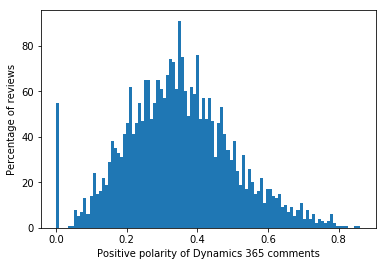

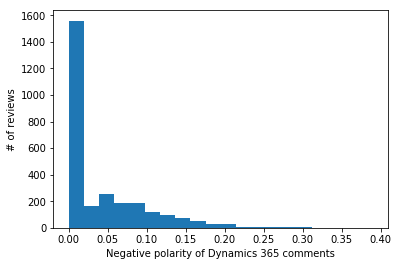

In [36]:
plt.hist(pos, bins= 100)
plt.xlabel('Positive polarity of Dynamics 365 comments')
plt.ylabel('Percentage of reviews')
plt.show()
plt.hist(neg, bins= 20)
plt.xlabel('Negative polarity of Dynamics 365 comments')
plt.ylabel('# of reviews')
plt.show()

In [37]:
nlp = en_core_web_sm.load()

In [38]:
D365_DroppingNas['Review_Comments'][0]

'everything one place sale marketing finance field service customer service operation automation available product market right likable thing customer support dynamic see erp crm team provide enables real sense productive intelligent decision easy adopt accessing managing pc mobile web browser make accessible powerful look feel control feature ui different kind user another best thing make standout enterprise business edition fantastic come design functionality integration office 365 social apps give lot control feature security crm erp love look feel kinda mashup microsoft word outlook excel etc bit difficult use ease start knowledge curve first time microsoft product user little slower challenging first time user familiar microsoft product microsoft dynamic work business work come management draw chart needed provides accurate data deeply analysis filter make easier get exact data want integration office 360 sharepoint office online coolest part deployment much easy cost license depl

In [39]:
doc = nlp(D365_DroppingNas['Review_Comments'][0])
print([(x.text, x.label_) for x in doc.ents])

[('one', 'CARDINAL'), ('365', 'CARDINAL'), ('first', 'ORDINAL'), ('first', 'ORDINAL'), ('360', 'CARDINAL'), ('five', 'CARDINAL'), ('ten', 'CARDINAL')]


In [40]:
print([(x,x.ent_type) for x in nlp(D365_DroppingNas['Review_Comments'][0])])

[(everything, 0), (one, 397), (place, 0), (sale, 0), (marketing, 0), (finance, 0), (field, 0), (service, 0), (customer, 0), (service, 0), (operation, 0), (automation, 0), (available, 0), (product, 0), (market, 0), (right, 0), (likable, 0), (thing, 0), (customer, 0), (support, 0), (dynamic, 0), (see, 0), (erp, 0), (crm, 0), (team, 0), (provide, 0), (enables, 0), (real, 0), (sense, 0), (productive, 0), (intelligent, 0), (decision, 0), (easy, 0), (adopt, 0), (accessing, 0), (managing, 0), (pc, 0), (mobile, 0), (web, 0), (browser, 0), (make, 0), (accessible, 0), (powerful, 0), (look, 0), (feel, 0), (control, 0), (feature, 0), (ui, 0), (different, 0), (kind, 0), (user, 0), (another, 0), (best, 0), (thing, 0), (make, 0), (standout, 0), (enterprise, 0), (business, 0), (edition, 0), (fantastic, 0), (come, 0), (design, 0), (functionality, 0), (integration, 0), (office, 0), (365, 397), (social, 0), (apps, 0), (give, 0), (lot, 0), (control, 0), (feature, 0), (security, 0), (crm, 0), (erp, 0), (lo

In [41]:
doc1 = D365_DroppingNas['Review_Comments'].apply(lambda x : nlp(x))

In [52]:
type(doc1)

pandas.core.series.Series

In [42]:
len(doc1)

2791

In [111]:
dir(doc1)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_prepare__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__

In [49]:
NER_Dyanmics365 = [[(x,x.ent_type) for x in doc1[i]] for i in doc1.index]

In [114]:
NER_Dyanmics365_temp = [[(x,x.tag_,x.ent_type_) for x in nlp(D365_DroppingNas['Review_Comments'][i])] for i in D365_DroppingNas.index]

In [115]:
NER_Dyanmics365_temp

[[(everything, 'NN', ''),
  (one, 'CD', 'CARDINAL'),
  (place, 'NN', ''),
  (sale, 'NN', ''),
  (marketing, 'NN', ''),
  (finance, 'NN', ''),
  (field, 'NN', ''),
  (service, 'NN', ''),
  (customer, 'NN', ''),
  (service, 'NN', ''),
  (operation, 'NN', ''),
  (automation, 'NN', ''),
  (available, 'JJ', ''),
  (product, 'NN', ''),
  (market, 'NN', ''),
  (right, 'JJ', ''),
  (likable, 'JJ', ''),
  (thing, 'NN', ''),
  (customer, 'NN', ''),
  (support, 'NN', ''),
  (dynamic, 'JJ', ''),
  (see, 'VB', ''),
  (erp, 'NN', ''),
  (crm, 'NN', ''),
  (team, 'NN', ''),
  (provide, 'VBP', ''),
  (enables, 'VBZ', ''),
  (real, 'JJ', ''),
  (sense, 'NN', ''),
  (productive, 'JJ', ''),
  (intelligent, 'JJ', ''),
  (decision, 'NN', ''),
  (easy, 'RB', ''),
  (adopt, 'VB', ''),
  (accessing, 'VBG', ''),
  (managing, 'VBG', ''),
  (pc, 'JJ', ''),
  (mobile, 'JJ', ''),
  (web, 'NN', ''),
  (browser, 'NN', ''),
  (make, 'VBP', ''),
  (accessible, 'JJ', ''),
  (powerful, 'JJ', ''),
  (look, 'NN', ''),
  (

In [90]:
print(type(NER_Dyanmics365))
print(len(NER_Dyanmics365))
print(len(NER_Dyanmics365_temp))

<class 'list'>
2791
2791


In [116]:
def TextProcessingAndNER(PandasSeriesWithReviews,DroppingNas = pd.DataFrame(), NER_temp = []):
    DroppingNas = PandasSeriesWithReviews[['Main_comment', 'Reviewed_On', 'Reviewer_name','Reviewer_Department_company', 'Review_Comments']]
    DroppingNas = DroppingNas.dropna()
    DroppingNas['Review_Comments'] = DroppingNas['Review_Comments'].apply(lambda x : re.sub(r'\W+',' ',str(x)))
    DroppingNas['Review_Comments'] = DroppingNas['Review_Comments'].apply(lambda x : " ".join(x.lower() for x in x.split()))
    DroppingNas['Review_Comments'] = DroppingNas['Review_Comments'].apply(lambda x : " ".join(x for x in x.split() if x not in stop_words))
    DroppingNas['Review_Comments'] = DroppingNas['Review_Comments'].apply(lambda x: " ".join(lemmatizer.lemmatize(x) for x in x.split()))
    NER_temp.append([[(x,x.tag_,x.ent_type_) for x in nlp(DroppingNas['Review_Comments'][i])] for i in DroppingNas.index])
    return NER_temp

In [117]:
NER_Dyanmics365_temp2 = TextProcessingAndNER(Dynamics365_Data[:10])

In [118]:
print(NER_Dyanmics365_temp2)
print("Length of this data", len(NER_Dyanmics365_temp2))

[[[(everything, 'NN', ''), (one, 'CD', 'CARDINAL'), (place, 'NN', ''), (sale, 'NN', ''), (marketing, 'NN', ''), (finance, 'NN', ''), (field, 'NN', ''), (service, 'NN', ''), (customer, 'NN', ''), (service, 'NN', ''), (operation, 'NN', ''), (automation, 'NN', ''), (available, 'JJ', ''), (product, 'NN', ''), (market, 'NN', ''), (right, 'JJ', ''), (likable, 'JJ', ''), (thing, 'NN', ''), (customer, 'NN', ''), (support, 'NN', ''), (dynamic, 'JJ', ''), (see, 'VB', ''), (erp, 'NN', ''), (crm, 'NN', ''), (team, 'NN', ''), (provide, 'VBP', ''), (enables, 'VBZ', ''), (real, 'JJ', ''), (sense, 'NN', ''), (productive, 'JJ', ''), (intelligent, 'JJ', ''), (decision, 'NN', ''), (easy, 'RB', ''), (adopt, 'VB', ''), (accessing, 'VBG', ''), (managing, 'VBG', ''), (pc, 'JJ', ''), (mobile, 'JJ', ''), (web, 'NN', ''), (browser, 'NN', ''), (make, 'VBP', ''), (accessible, 'JJ', ''), (powerful, 'JJ', ''), (look, 'NN', ''), (feel, 'VBP', ''), (control, 'NN', ''), (feature, 'NN', ''), (ui, 'VBD', ''), (different


Length of this data 1


In [142]:
len(NER_Dyanmics365_temp2[0])

10

In [148]:
NER_Dyanmics365_temp2[0][9]

[(customizations, 'NNS', ''),
 (workflow, 'JJ', ''),
 (view, 'NN', ''),
 (etc, 'FW', ''),
 (easy, 'JJ', ''),
 (create, 'VBP', ''),
 (manage, 'NN', ''),
 (like, 'IN', ''),
 (microsoft, 'NN', ''),
 (product, 'NN', ''),
 (error, 'NN', ''),
 (vague, 'JJ', ''),
 (difficult, 'JJ', ''),
 (troubleshoot, 'NN', ''),
 (managed, 'VBD', ''),
 (2011, 'CD', 'DATE'),
 (prem, 'NN', ''),
 (2015, 'CD', 'DATE'),
 (hosted, 'VBN', ''),
 (deployment, 'NN', ''),
 (enjoyed, 'VBD', ''),
 (deployed, 'VBN', ''),
 (within, 'IN', ''),
 (m, 'CD', ''),
 (stack, 'NN', ''),
 (easily, 'RB', ''),
 (managed, 'VBN', ''),
 (extended, 'VBN', ''),
 (though, 'IN', ''),
 (custom, 'NN', ''),
 (development, 'NN', ''),
 (becomes, 'VBZ', ''),
 (little, 'JJ', ''),
 (trickier, 'NN', ''),
 (bolting, 'NN', ''),
 (resource, 'NN', ''),
 (outside, 'IN', ''),
 (m, 'CD', ''),
 (stack, 'NN', ''),
 (overall, 'JJ', ''),
 (usability, 'NN', ''),
 (fantastic, 'JJ', ''),
 (always, 'RB', ''),
 (easy, 'JJ', ''),
 (time, 'NN', ''),
 (gaining, 'VBG', 

In [152]:
range(10)

range(0, 10)

In [160]:
new_list = []
for i,j in zip(range(len(D365_DroppingNas_HumanRedable[:10])),range(len(NER_Dyanmics365_temp2[0]))):
    new_list.append([D365_DroppingNas_HumanRedable['Review_Comments'][i],NER_Dyanmics365_temp2[0][j]])

In [161]:
new_list

[[" Everything in one place such as Sales, Marketing, Finance, Field service, Customer Service, Operations and the automation which is not available in other products that are in the market right now. Most likable thing is customer support of Dynamics which I didn't see any other ERP or CRM team provide. It enables me in a real sense to be productive, intelligent in decisions and it was very very easy to adopt. Accessing and managing from PC, Mobile or a Web Browser makes it more accessible and more powerful. The look and feel (Controls/features/UI) for a different kind of user is another best thing which makes it standout.     Both Enterprise and Business edition are fantastic when it comes to their design and functionalities, and the integrations with office 365 and other social apps give a lot more control and features and security which no any other CRM or ERP can, that's why I love it. , It looks and feels kinda mashup of Microsoft Word, Outlook, Excel, etc then it's a bit difficu

In [157]:
print(D365_DroppingNas_HumanRedable['Review_Comments'][0],NER_Dyanmics365_temp2[0][0])

 Everything in one place such as Sales, Marketing, Finance, Field service, Customer Service, Operations and the automation which is not available in other products that are in the market right now. Most likable thing is customer support of Dynamics which I didn't see any other ERP or CRM team provide. It enables me in a real sense to be productive, intelligent in decisions and it was very very easy to adopt. Accessing and managing from PC, Mobile or a Web Browser makes it more accessible and more powerful. The look and feel (Controls/features/UI) for a different kind of user is another best thing which makes it standout.     Both Enterprise and Business edition are fantastic when it comes to their design and functionalities, and the integrations with office 365 and other social apps give a lot more control and features and security which no any other CRM or ERP can, that's why I love it. , It looks and feels kinda mashup of Microsoft Word, Outlook, Excel, etc then it's a bit difficult 

In [156]:
print(D365_DroppingNas_HumanRedable['Review_Comments'][0])

" Everything in one place such as Sales, Marketing, Finance, Field service, Customer Service, Operations and the automation which is not available in other products that are in the market right now. Most likable thing is customer support of Dynamics which I didn't see any other ERP or CRM team provide. It enables me in a real sense to be productive, intelligent in decisions and it was very very easy to adopt. Accessing and managing from PC, Mobile or a Web Browser makes it more accessible and more powerful. The look and feel (Controls/features/UI) for a different kind of user is another best thing which makes it standout.     Both Enterprise and Business edition are fantastic when it comes to their design and functionalities, and the integrations with office 365 and other social apps give a lot more control and features and security which no any other CRM or ERP can, that's why I love it. , It looks and feels kinda mashup of Microsoft Word, Outlook, Excel, etc then it's a bit difficult